In [1]:
import os
import cv2
from pathlib import Path
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments, Trainer
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from datasets import DatasetDict
from PIL import Image



In [ ]:
#Нарезаем объекты для обучения согласно аннотации
# Функция для чтения классов из файла
def read_classes(file_path):
    with open(file_path, 'r') as file:
        classes = file.read().strip().split()
    return classes

# Путь к файлу с описанием классов
classes_file = 'classes.txt'
class_names = read_classes(classes_file)

# Папки для хранения вырезанных изображений по классам
output_dirs = {class_name: f'output/{class_name}' for class_name in class_names}

# Создание папок, если они не существуют
for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Функция для вырезания объектов из изображения
def extract_objects(image_path, annotations_path):
    # Чтение изображения
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    # Чтение аннотаций
    with open(annotations_path, 'r') as file:
        lines = file.readlines()
    
    # Обработка каждой аннотации
    obj_count = 0
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        cx, cy, w, h = map(float, parts[1:])
        
        # Преобразование относительных координат в абсолютные
        x1 = int((cx - w / 2) * width)
        y1 = int((cy - h / 2) * height)
        x2 = int((cx + w / 2) * width)
        y2 = int((cy + h / 2) * height)
        
        # Вырезание объекта
        cropped_img = image[y1:y2, x1:x2]
        
        # Генерация имени файла и сохранение в соответствующую папку
        class_name = class_names[class_id]
        output_dir = output_dirs[class_name]
        base_filename = os.path.basename(image_path).replace('.jpg', f'_{class_name}_{obj_count}.jpg')
        output_path = os.path.join(output_dir, base_filename)
        cv2.imwrite(output_path, cropped_img)
        
        # Увеличение счетчика объектов
        obj_count += 1

# Путь к папкам с изображениями и аннотациями
images_dir = '/mnt/data/images'
labels_dir = '/mnt/data/label'

# Получение списка файлов изображений и аннотаций
image_files = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.jpg')]
annotation_files = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith('.txt')]

# Убедимся, что списки файлов совпадают по длине
assert len(image_files) == len(annotation_files), "Количество изображений и аннотаций не совпадает!"

# Обработка всех файлов
for img_file, ann_file in zip(image_files, annotation_files):
    extract_objects(img_file, ann_file)

print("Вырезанные изображения сохранены в папке 'output'.")

In [2]:
#Проверим, что данные сохранились
# Загрузка данных
dataset = load_dataset('imagefolder', data_dir='Z:\\Hakatons\\Welding\\output')

# Вывод структуры датасета
print(dataset)

# Вывод примера данных
print(dataset['train'][0])


Resolving data files:   0%|          | 0/3541 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3541
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=43x57 at 0x1CE9CC62040>, 'label': 0}


In [3]:
#Проверим cuda устройство
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))



True
0
NVIDIA GeForce RTX 3090 Ti


In [4]:
import os
from pathlib import Path
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from datasets import DatasetDict

# Загрузка данных
dataset = load_dataset('imagefolder', data_dir='Z:\\Hakatons\\Welding\\output')

# Разделение датасета на обучающую и тестовую выборки
dataset = dataset['train'].train_test_split(test_size=0.2)  # 20% для тестирования

# Определение модели и токенизатора (image processor)
model_name = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(dataset['train'].features['label'].names), ignore_mismatched_sizes=True)

# Определение трансформаций для изображений
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size['height']  # Используем конкретное значение размера
_transforms = Compose([
    Resize((size, size)),  # Применяем Resize с корректными значениями
    CenterCrop(size),
    ToTensor(),  # Преобразуем изображение в тензор
    normalize,
])

def transform(example):
    """Функция для применения трансформаций к изображению"""
    if 'image' in example:
        example['pixel_values'] = _transforms(example['image'])
    return example

# Применяем трансформации к датасету
dataset = dataset.map(transform, batched=False)

# Создаем абсолютный путь для результатов
output_dir = Path('./results')
os.makedirs(output_dir, exist_ok=True)

# Определение параметров обучения
training_args = TrainingArguments(
    output_dir=str(output_dir),  # Директория для сохранения модели и других результатов
    eval_strategy="epoch",  # Изменено на eval_strategy
    learning_rate=5e-5,
    per_device_train_batch_size=160, #Устанавливаем размер в зависимости от количества видеопамяти
    per_device_eval_batch_size=160, #Устанавливаем размер в зависимости от количества видеопамяти
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=str(output_dir / 'logs'),  # Директория для логов
    report_to="none",  # Отключаем TensorBoard
    dataloader_num_workers=0,  # Отключаем многопроцессорную загрузку данных для отладки
    fp16=False,  # Отключаем половинную точность для упрощения отладки
    logging_steps=10,  # Логгируем чаще
)

# Функция data_collator
def data_collator(data):
    pixel_values = [item['pixel_values'] for item in data]
    # Добавляем проверку, что все элементы являются тензорами
    for i in range(len(pixel_values)):
        if isinstance(pixel_values[i], list):
            pixel_values[i] = torch.tensor(pixel_values[i])
    pixel_values = torch.stack(pixel_values)
    labels = torch.tensor([item['label'] for item in data])
    return {'pixel_values': pixel_values, 'labels': labels}

# Определение Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    data_collator=data_collator
)

# Обучение модели
trainer.train()


Resolving data files:   0%|          | 0/3541 [00:00<?, ?it/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2832 [00:00<?, ? examples/s]

Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.018500,0.396934
2,0.240100,0.239313
3,0.103900,0.205639


TrainOutput(global_step=54, training_loss=0.36874069218282346, metrics={'train_runtime': 1125.3554, 'train_samples_per_second': 7.55, 'train_steps_per_second': 0.048, 'total_flos': 6.583896461040353e+17, 'train_loss': 0.36874069218282346, 'epoch': 3.0})

Evaluation results: {'eval_loss': 0.20563940703868866, 'eval_runtime': 69.2896, 'eval_samples_per_second': 10.232, 'eval_steps_per_second': 0.072, 'epoch': 3.0}
Accuracy: 0.9351198871650211
Precision: 0.9340992312682359
Recall: 0.9351198871650211
F1-Score: 0.9343947144766007


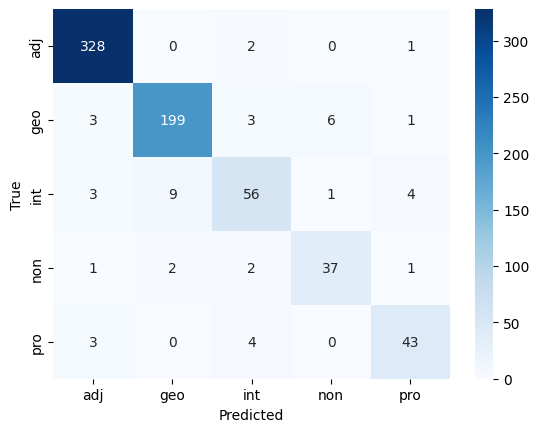

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Оценка модели
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Выполнение предсказаний
predictions, labels, _ = trainer.predict(dataset['test'])
predicted_labels = predictions.argmax(axis=1)

# Вычисление метрик
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Анализ предсказаний по confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['test'].features['label'].names, yticklabels=dataset['test'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [6]:
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from transformers import ViTForImageClassification, ViTImageProcessor

# Функция загрузки изображения
def load_image(image_path):
    return Image.open(image_path)

# Функция предобработки изображения
def preprocess_image(image, image_processor):
    transforms = Compose([
        Resize((image_processor.size['height'], image_processor.size['width'])),
        CenterCrop(image_processor.size['height']),
        ToTensor(),
        Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    ])
    return transforms(image)

# Загрузка модели и процессора изображений из локальной директории
output_dir = Path('./results/checkpoint-54')
model = ViTForImageClassification.from_pretrained(output_dir)
image_processor = ViTImageProcessor.from_pretrained(output_dir)

# Классификация изображения
def classify_image(image_path):
    image = load_image(image_path)
    image = preprocess_image(image, image_processor)
    image = image.unsqueeze(0)  # Добавляем batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()

    return dataset['train'].features['label'].names[predicted_class_idx]



# Пример использования
image_path = 'Z:\\Hakatons\\Welding\\test\\1.jpg'
predicted_class = classify_image(image_path)
print(f"Predicted class: {predicted_class}")


Predicted class: pro
